I want to diagnoise the bird's audio among all the background noise.

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
!mkdir -p /root/.kaggle
!mv /content/kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download -d tahouramorovati/male-zebra-finch-labeled-audio-file-ipm

 97% 33.0M/34.0M [00:00<00:00, 99.4MB/s]
100% 34.0M/34.0M [00:00<00:00, 85.2MB/s]


In [ ]:
!unzip /content/male-zebra-finch-labeled-audio-file-ipm.zip

Archive:  /content/male-zebra-finch-labeled-audio-file-ipm.zip
  inflating: male_noise_song_call.mp3  
  inflating: male_noise_song_call_labels.csv  
  inflating: male_noise_song_call_legend.txt  


# CSV Preprocessing

In this part, we remove the information that are not useful and we can not extract features out of them because they are too small and they do not have enough data.

In [ ]:
import pandas as pd

csv_file_path = '/content/male_noise_song_call_labels.csv'
df = pd.read_csv(csv_file_path)
tolerance = 1e-10 # defining a level in which the label does now include information anymore

start_stop_diff = df.iloc[:,1] - df.iloc[:,0]
filtered_columns = start_stop_diff[abs(start_stop_diff) > tolerance].index
filtered_df = df.iloc[filtered_columns]
columns = ["start_time", "stop_time", "label"]
filtered_df.columns = columns
filtered_df.reset_index(drop=True, inplace=True)
# index=False this part does not save the index in the csv file
filtered_df.to_csv('male_noise_song_call_labels_EDITED.csv', index=False)
filtered_df

,start_time,stop_time,label
0,70.278698,70.530004,tet
1,72.268637,72.735349,tet
2,74.725288,75.207387,tet
3,77.874316,78.207682,tet
4,79.884769,80.120690,tet
...,...,...,...
306,1770.977021,1771.248469,DC
307,1772.985734,1773.222437,DC
308,1787.465841,1787.745975,DC
309,1790.584233,1790.710184,tet


# Creating a Label array

In [ ]:
import pandas as pd
import librosa
import numpy as np
import seaborn as sns

audio_path = "/content/male_noise_song_call.mp3"
audio, sr = librosa.load(audio_path, sr=None)

csv_file_path = '/content/male_noise_song_call_labels_EDITED.csv'
df = pd.read_csv(csv_file_path)
# get the total duration
total_duration = int(np.ceil(df.iloc[:,1].max()))
# Create a time array
time_array = np.zeros(total_duration * sr)
voice_length = []
for index in range(len(df)):
    start_time = int(df.iloc[index,0]* sr)
    stop_time = int(df.iloc[index,1]* sr)
    #print(stop_time- start_time)
    voice_length.append(stop_time- start_time)
    time_array[start_time:stop_time + 1] = 1
    #print(time_array[start_time:stop_time + 1])

# so far we have a label file to compare every window with
label_array = time_array

In [ ]:
np.where(voice_length==np.min(voice_length))

(array([2]),)

In [ ]:
voice_length

2555
2555
52288.91604707133


<ipython-input-3-23116d7ce0de>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(voice_length)


<Axes: ylabel='Density'>

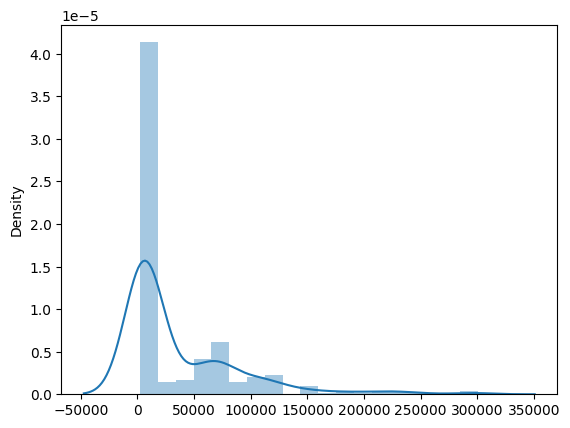

In [ ]:
x = np.min(voice_length[3:])
print(x)
print(np.min(voice_length))
print(np.std(voice_length))

sns.distplot(voice_length)


In [ ]:
print(len(label_array))
np.count_nonzero(label_array)

79115400


11196607

# Calculate STFT and Compare it to Label Array

In [ ]:
def calculate_label_for_window(index, window, window_size):
   element = label_array[index:index + window_size]
   count_ones = np.count_nonzero(element)
   if int(len(window)) == count_ones :
        # more than % 50 of the window is filled with one labels.
        return 1
   elif count_ones == 0 :
        return 0
   else:
        return 2 #non-decision


features = []
labels = []
# now we want to calculate the STFT of each window and
# compare it to the label file
window_size = 2048  # example window size
hop_length = 512   # example hop length

for i in range(0, len(audio), hop_length):
  window = audio[i:i+window_size]
  if len(window) == window_size:
    windowed_signal = window * np.hanning(window_size)
    # Calculate the FFT
    fft_result = np.fft.rfft(windowed_signal)
    # Take the magnitude (absolute value) of the FFT result
    feature = np.abs(fft_result)
    features.append(feature)
    label = calculate_label_for_window(i, window, window_size)
    # QS : should we have n ones for each window or only 1 , one.
    labels.append(label)

In [ ]:
type(labels)

list

In [ ]:
len(features)

154472

In [ ]:
len(features[0])

1025

# Plot Data

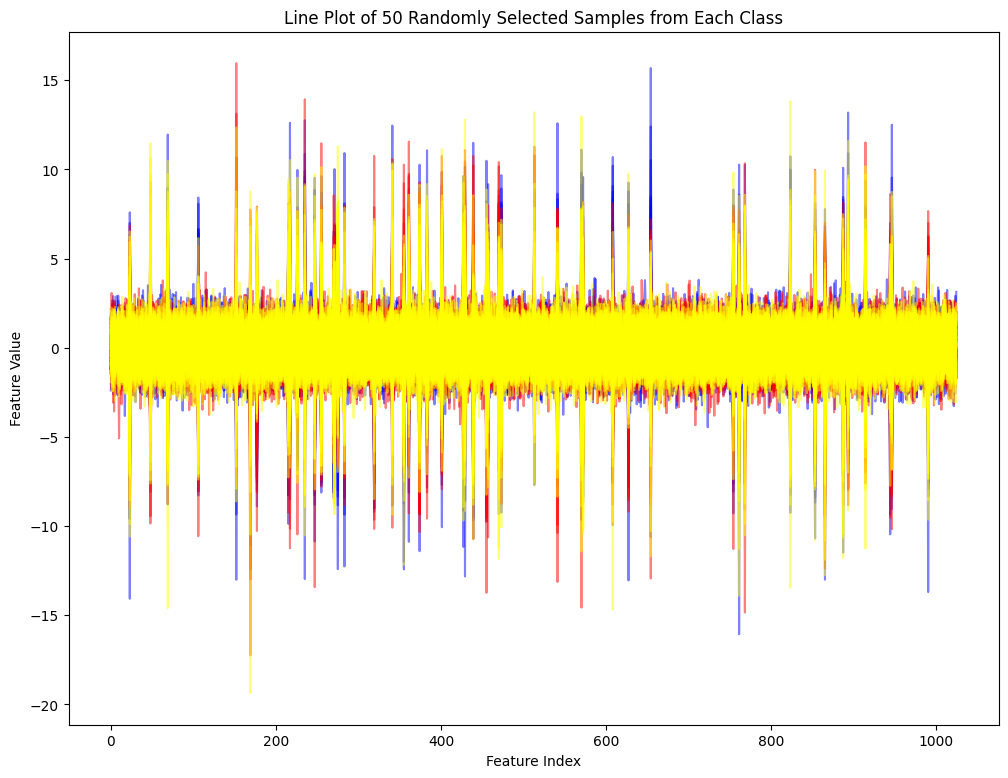

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

# Simulating a dataset (replace this with your actual data loading code)
X, y = make_classification(n_samples=154472, n_features=1025, n_informative=50, n_redundant=0, n_clusters_per_class=1, n_classes=3, random_state=42)

# Separate samples by class
class_indices_0 = np.where(y == 0)[0]
class_indices_1 = np.where(y == 1)[0]
class_indices_2 = np.where(y == 2)[0]

# Randomly select 50 samples from each class
np.random.seed(42)  # Ensure reproducibility
sample_indices_0 = np.random.choice(class_indices_0, 50, replace=False)
sample_indices_1 = np.random.choice(class_indices_1, 50, replace=False)
sample_indices_2 = np.random.choice(class_indices_2, 50, replace=False)

# Get the samples
X_subset_0 = X[sample_indices_0, :]
X_subset_1 = X[sample_indices_1, :]
X_subset_2 = X[sample_indices_2, :]

# Plotting
plt.figure(figsize=(12, 9))

# Plot each class with its designated color
for sample in X_subset_0:
    plt.plot(sample, color='blue', alpha=0.5)
for sample in X_subset_1:
    plt.plot(sample, color='red', alpha=0.5)
for sample in X_subset_2:
    plt.plot(sample, color='yellow', alpha=0.5)

plt.title('Line Plot of 50 Randomly Selected Samples from Each Class')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()



# Train SVM

## Traditional SVM Implementation
In its classic form, SVM is a standalone algorithm used for classification and regression tasks. It works by finding the hyperplane that best separates different classes in the feature space. The traditional implementation of SVM, such as the one provided by Scikit-learn in Python, directly applies the SVM algorithm for this purpose. Here, the kernel trick is often used to make the algorithm effective in higher-dimensional spaces, allowing it to handle nonlinear relationships.

running started at 3:20

In this step I asked myself what is the reason that I use SVM, so I ask chatGPT 4.0, I have 154472 samples and each sample has 1025 dimensions, and I have 3 classes, 0,1,2 --> what is the best way to do the classification problem?
here are the solutions:

1. SVM
2. Random-Forest
3. Gradient Boosting Machines
4. Dimensionality Reduction Techniques
5. Deep Learning
6. Regularization Techniques
7. Feature Selection

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create a Support Vector Machine (SVM) classifier
clf = svm.SVC(kernel='rbf')  # You can choose different kernels (linear, rbf, etc.)

# Train the SVM classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


KeyboardInterrupt: 